In [3]:
import networkx as nx
import numpy as np
import pandas as pd
import os
import random
from scipy.sparse import csr_matrix
from sklearn.metrics import roc_auc_score
random.seed(4)
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [4]:
class DMBI_hackathon_ddi_utils():
    NODE_1 = 'node1'
    NODE_2 = 'node2'
    def __init__(self,number_of_drugs = 1434):
        self.number_of_drugs = number_of_drugs

    def write_list_to_file(self, list, path):
        thefile = open(path, 'w')
        for item in list:
            thefile.write("%s\n" % item)
        thefile.close()

    def read_sparse_matrix(self,train_data):
        print('creating matrix')
        x = train_data[self.NODE_1]
        y = train_data[self.NODE_2]
        assert len(x) == len(y)
        data = [1] * len(x)
        m = csr_matrix((data,(x,y)), shape=(self.number_of_drugs, self.number_of_drugs),dtype='f')
        print('m shape:', m.shape, 'm non zeros:', m.nnz)
        assert np.allclose(m.todense(), m.T.todense(), atol=1e-8) #matrix is symmetric
        return m.todense()#the matrix is small, sparse matrix is not necessary.
    
    def write_solution_to_file(self,preds,file_path, num_interactions_train):
        #preds is assumed to be ordered by confidence level
        #adds the header to the soution, combines the node IDs and writes the soךution to file
        #asserts are important. Note them.
        
        print('writing predictions to file: ',file_path)
        for u, v in preds:
           assert u < v, 'graph is undirected, predict edges where the first node id is smaller than the second only'
        assert len(preds) == (self.number_of_drugs * self.number_of_drugs - self.number_of_drugs - num_interactions_train) / 2, "number of predictions is equal to number of non existing edges"
        output = [','.join([self.NODE_1 + '_' + self.NODE_2])]+[','.join([str(p[0]) +'_' + str(p[1])]) for p in preds]
        self.write_list_to_file(output,file_path)

    def create_holdout_set(self, m_train, train_percent = 0.9):
        # create holdout set. the set will contain both existing and non-existing edges
        m_train_holdout = np.matrix(m_train)
        validation_set = set()
        for i in range(self.number_of_drugs):
            for j in range(i+1, self.number_of_drugs):
                if random.random() > train_percent:
                    validation_set.add((i, j))
                    m_train_holdout[i, j] = 0
                    m_train_holdout[j, i] = 0
        return m_train_holdout, validation_set

    def average_precision_at_k(self, k, class_correct):
        #return average precision at k
        #more examples: https://github.com/benhamner/Metrics/blob/master/Python/ml_metrics/average_precision.py
        #and: https://www.kaggle.com/c/avito-prohibited-content#evaluation
        #class_correct is a list with the binary correct label ordered by confidence level.
        assert k <= len(class_correct) and k > 0        
        score = 0.0
        hits = 0.0
        for i in range(k):
            if class_correct[i] == 1:
                hits += 1.0
            score += hits / (i+1.0)
        score /= k
        return score



In [5]:
#simple prediction class
class link_prediction_predictor:
    def __init__(self, number_of_drugs):
        self.G = nx.Graph()
        self.G.add_nodes_from(range(number_of_drugs))

    def fit(self, edge_list):
        self.G.add_edges_from(edge_list)

    def predict(self,prediction_set=None):
        preds = nx.resource_allocation_index(self.G, ebunch=prediction_set)  
        # if ebunch is None then all non-existent edges in the graph will be used.
        preds = [(u1, v1) for (p, u1, v1) in sorted([(prediction, u, v) for (u, v, prediction) in preds],reverse=True)]  
        #predictions are expected as described in write_solution_to_file. The values are suppose to be ordered by confidence.
        return preds

In [6]:
def jac(A):
    # compute Jackard coefficients    
    cuts = A*A
    d = A.sum(1)
    joins = np.tile(d, [1,A.shape[0]])
    joins = joins + joins.T - cuts   
    J = cuts/joins
    np.nan_to_num(J, copy=False)   
    np.fill_diagonal(J, 1) 
    
    return J

In [7]:
def joins(A):
    # compute Jackard coefficients    
    cuts = A*A
    d = A.sum(1)
    joins = np.tile(d, [1,A.shape[0]])
    joins = joins + joins.T - cuts   
    np.fill_diagonal(joins, 1) 
    
    return joins

In [8]:
def cos_sim(A):
    # cosine similarity
    prods = A*A
    norms = np.sqrt(np.sum(np.multiply(A,A), 1))
    prods /= norms
    prods = prods.T
    prods /= norms
    np.nan_to_num(prods, copy=False)   
    return prods

In [9]:
def smart_thresh(A, Sim, k, g=10):
    n = A.shape[0]
    print('min: {}, max: {}'.format(np.min(Sim), np.max(Sim)))
    T = sorted(np.linspace(np.min(Sim), np.max(Sim), g), reverse=True)
    for i_T in range(len(T)):
        th = T[i_T]
        Sim_th = (Sim>th).astype(int)
        Score = Sim_th*A*Sim_th
        np.fill_diagonal(Score, 0)
        pos_scores = [Score[i,j] for j in range(n) for i in range(j) if (A[i,j]==0 and Score[i,j]>0)]
        count_pos_scores = len(pos_scores)
        #print('th = {}, count = {}'.format(th, count_pos_scores))
        if count_pos_scores > k:
            print('\nthreshold {} gives count of {}'.format(th, count_pos_scores))
            return th
    print('\nthreshold: {} gives count of {}'.format(th, count_pos_scores))
    return th

In [37]:
# def jac_predict_smart_thresh(A, k, g, self_jac=1):
    
#     n = A.shape[0]
#     J = jac(A)  
#     thresh = smart_thresh(A, J, k, g)
#     J = (J>thresh).astype(int)
#     np.fill_diagonal(J, self_jac) 
    
#     Score = J*A*J
#     np.fill_diagonal(Score, 0)    

#     scores = [(i , j, Score[i,j]) for j in range(n) for i in range(j) if A[i,j]==0]
# #    scores = [(i , j, Score[i,j]) for (i,j) in validation_set]
#     preds = [(u1, v1) for (s, u1, v1) in sorted([(s, u, v) for (u, v, s) in scores], reverse=True)]  

#     return preds

In [10]:
def predict_thresh(A, Sim, thresh, self_sim=1):
    
    n = A.shape[0]
    Sim = (Sim>thresh).astype(int)
    np.fill_diagonal(Sim, self_sim) 
    
    Score = Sim*A*Sim
    np.fill_diagonal(Score, 0)    

    scores = [(i , j, Score[i,j]) for j in range(n) for i in range(j) if A[i,j]==0]
    preds = [(u1, v1) for (s, u1, v1) in sorted([(s, u, v) for (u, v, s) in scores], reverse=True)]  

    return preds

In [11]:
def predict_thresh_diag(A, Sim, thresh, self_sim=1):
    
    n = A.shape[0]
    Sim = (Sim>thresh).astype(int)
    np.fill_diagonal(Sim, self_sim) 
    
    Score = Sim*A + A*Sim
    np.fill_diagonal(Score, 0)    

    scores = [(i , j, Score[i,j]) for j in range(n) for i in range(j) if A[i,j]==0]
    preds = [(u1, v1) for (s, u1, v1) in sorted([(s, u, v) for (u, v, s) in scores], reverse=True)]  

    return preds

In [17]:
def predict_soft_diag(A, Sim, self_sim=1):
    
    n = A.shape[0]
    np.fill_diagonal(Sim, self_sim) 
    
    thresh = .5
    Sim_old = Sim.copy()
    Sim = (Sim - thresh) / (1-thresh)
    Sim[Sim_old<thresh] = 0
    np.fill_diagonal(Sim, self_sim) 
    
    Score = Sim*A + A*Sim
    np.fill_diagonal(Score, 0)    

    scores = [(i , j, Score[i,j]) for j in range(n) for i in range(j) if A[i,j]==0]
    preds = [(u1, v1) for (s, u1, v1) in sorted([(s, u, v) for (u, v, s) in scores], reverse=True)]  

    return preds

In [38]:
# def cos_sim_predict_smart_thresh(A, k, g, self_jac=1):
    
#     n = A.shape[0]
#     J = cos_sim(A)  
#     thresh = smart_thresh(A, J, k, g)
#     J = (J>thresh).astype(int)
#     np.fill_diagonal(J, self_jac) 
    
#     Score = J*A*J
#     np.fill_diagonal(Score, 0)    

#     scores = [(i , j, Score[i,j]) for j in range(n) for i in range(j) if A[i,j]==0]
# #    scores = [(i , j, Score[i,j]) for (i,j) in validation_set]
#     preds = [(u1, v1) for (s, u1, v1) in sorted([(s, u, v) for (u, v, s) in scores], reverse=True)]  

#     return preds

In [39]:
# def jac_predict_smart_soft_thresh(A, k, g, self_jac=1):
    
#     n = A.shape[0]
#     J = jac(A)  
#     #thresh = smart_thresh(A, J, k, g)
#     thresh = .5
#     J_old = J.copy()
#     J = (J - thresh) / (1-thresh)
#     J[J_old<thresh] = 0
#     np.fill_diagonal(J, self_jac) 
    
#     Score = J*A*J
#     np.fill_diagonal(Score, 0)    

#     scores = [(i , j, Score[i,j]) for j in range(n) for i in range(j) if A[i,j]==0]
# #    scores = [(i , j, Score[i,j]) for (i,j) in validation_set]
#     preds = [(u1, v1) for (s, u1, v1) in sorted([(s, u, v) for (u, v, s) in scores], reverse=True)]  

#     return preds

In [18]:
def check_preds(preds, A):
    for (i,j) in preds:
        if A[i,j]:
            print('Error: preds contain an existing edge: ({},{})'.format(i,j))
            return
    print('Good: preds do not contain existing edges!')

In [19]:
DMBI_hackathon_ddi = DMBI_hackathon_ddi_utils()
train_matrix = DMBI_hackathon_ddi.read_sparse_matrix(pd.read_csv('train.csv'))

creating matrix
m shape: (1434, 1434) m non zeros: 93200


In [42]:
#Evaluate model. 
#Note that holdout is based on random decision. 
#Test set contains new interactions that random selection does not emulate.

In [20]:
def test_preds(preds, m_train_holdout, train_matrix):
#     print(len(preds))
#     s = [x[2] for x in preds if x[2]>0]
#     print(len(s))
    check_preds(preds, m_train_holdout)
    class_correct = [train_matrix[x[0],x[1]] for x in preds]
    average_precision = DMBI_hackathon_ddi.average_precision_at_k(k=1000,class_correct=class_correct)
    print('average precision @ 1000: ', average_precision)
    average_precision = DMBI_hackathon_ddi.average_precision_at_k(k=2000,class_correct=class_correct)
    print('average precision @ 2000: ', average_precision)    

In [23]:
def test_methods(percent):
    
    print('\ncomputing validation on', percent)
    A, validation_set = DMBI_hackathon_ddi.create_holdout_set(train_matrix, train_percent=percent)

#     Sim = joins(A)
#     thresh = smart_thresh(A, Sim, k=4000, g=20)
#     print('\njoins, k=4000, g=20, self_jac only')
#     preds = predict_thresh_diag(A, Sim, thresh)
#     test_preds(preds, A, train_matrix)    

    Sim = cos_sim(A)
    #thresh = smart_thresh(A, Sim, k=4000, g=50)
    print('\ncos_sim, sof_diag, self_jac only')
    preds = predict_soft_diag(A, Sim)
    test_preds(preds, A, train_matrix)    

    Sim = cos_sim(A)
    thresh = smart_thresh(A, Sim, k=8000, g=50)
    print('\ncos_sim, k=8000, g=20, self_jac only')
    preds = predict_thresh_diag(A, Sim, thresh)
    test_preds(preds, A, train_matrix)    

    Sim = cos_sim(A)
    thresh = smart_thresh(A, Sim, k=1000, g=50)
    print('\ncos_sim, k=1000, g=20, self_jac only')
    preds = predict_thresh_diag(A, Sim, thresh)
    test_preds(preds, A, train_matrix)    
    
    Sim = (jac(A) + cos_sim(A)) / 2
    thresh = smart_thresh(A, Sim, k=4000, g=20)
    print('\nmean, k=4000, g=20, self_jac only')
    preds = predict_thresh_diag(A, Sim, thresh)
    test_preds(preds, A, train_matrix)    
    
    Sim = jac(A)
    thresh = smart_thresh(A, Sim, k=4000, g=20)
    print('\njac, k=4000, g=20, self_jac only')
    preds = predict_thresh_diag(A, Sim, thresh)
    test_preds(preds, A, train_matrix)        
    
    

In [ ]:
# A
# [(i,j) for j in range(A.shape[0]) for i in range(j) if A[i,j]==0]

In [24]:
test_methods(.9)


computing validation on 0.9


/home/noa_raindel/.TF_cpu_new/lib/python3.5/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
/home/noa_raindel/.TF_cpu_new/lib/python3.5/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys



cos_sim, sof_diag, self_jac only
Good: preds do not contain existing edges!
average precision @ 1000:  0.9765813728536469
average precision @ 2000:  0.9403091876759349
min: 0.0, max: 1.0000001192092896

threshold 0.8163266279259507 gives count of 8351

cos_sim, k=8000, g=20, self_jac only
Good: preds do not contain existing edges!
average precision @ 1000:  0.9831446870791749
average precision @ 2000:  0.9471940672318162
min: 0.0, max: 1.0000001192092896

threshold 0.8979592907185457 gives count of 1316

cos_sim, k=1000, g=20, self_jac only
Good: preds do not contain existing edges!
average precision @ 1000:  0.9249510963258069
average precision @ 2000:  0.7982800350838557
min: 0.0, max: 1.0

threshold 0.7894736842105263 gives count of 4350

mean, k=4000, g=20, self_jac only
Good: preds do not contain existing edges!
average precision @ 1000:  0.9866855176750767
average precision @ 2000:  0.9430929049590864
min: 0.0, max: 1.0

threshold 0.6842105263157894 gives count of 8359

jac, k=4

norms len: 1434


(array([5.64591e+05, 1.33525e+05, 8.88080e+04, 5.65930e+04, 3.74020e+04,
        2.61320e+04, 2.13730e+04, 1.89420e+04, 1.50770e+04, 1.22420e+04,
        1.01210e+04, 8.24700e+03, 6.90300e+03, 5.21600e+03, 3.96700e+03,
        3.16000e+03, 2.57800e+03, 2.26200e+03, 1.63700e+03, 1.44900e+03,
        1.09200e+03, 1.11000e+03, 7.99000e+02, 6.71000e+02, 7.47000e+02,
        5.78000e+02, 4.65000e+02, 4.39000e+02, 3.62000e+02, 9.73000e+02]),
 array([0.        , 0.03333334, 0.06666667, 0.10000001, 0.13333335,
        0.16666669, 0.20000002, 0.23333336, 0.2666667 , 0.30000004,
        0.33333337, 0.36666671, 0.40000005, 0.43333338, 0.46666672,
        0.50000006, 0.5333334 , 0.56666673, 0.60000007, 0.63333341,
        0.66666675, 0.70000008, 0.73333342, 0.76666676, 0.8000001 ,
        0.83333343, 0.86666677, 0.90000011, 0.93333344, 0.96666678,
        1.00000012]),
 <a list of 30 Patch objects>)

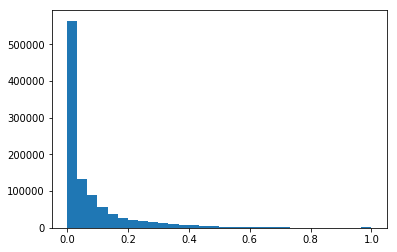

In [85]:
J_full = cos_sim(train_matrix)
J_vals = [J_full[i,j] for i in range(J_full.shape[0]) for j in range(i)]
plt.figure()
plt.hist(J_vals, 30)

In [25]:
#Create final submission file
train_matrix = DMBI_hackathon_ddi.read_sparse_matrix(pd.read_csv('train.csv'))
x,y = train_matrix.nonzero()
num_interactions_train = len(x); assert len(x)==len(y)
# edge_list = list(zip(x,y))
# link_prediction = link_prediction_predictor(DMBI_hackathon_ddi.number_of_drugs)
# link_prediction.fit(edge_list)
# preds = link_prediction.predict()

A = train_matrix
Sim = (cos_sim(A) + jac(A)) / 2
preds = predict_soft_diag(A, Sim,)

check_preds(preds, A)
print(len(preds))

DMBI_hackathon_ddi.write_solution_to_file(preds,'sample_predictions_V5.csv',num_interactions_train=num_interactions_train)

creating matrix
m shape: (1434, 1434) m non zeros: 93200
Good: preds do not contain existing edges!
980861
writing predictions to file:  sample_predictions_V5.csv
